# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
### Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from pylab import rcParams
import tensorflow as tf
import pickle
import time
import os
import cv2
import csv
from PIL import Image
%matplotlib inline

In [2]:
# Load pickled data
#import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file ="train.p"
validation_file="test.p"
testing_file = "valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# What's the shape of an image?
image_shape = X_train[0].shape

# How many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

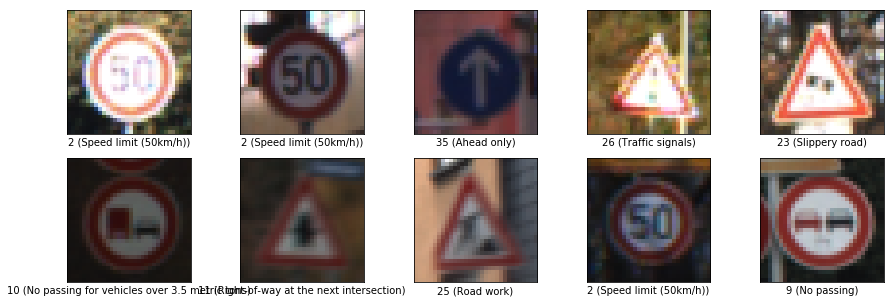

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
#import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
#%matplotlib inline
import csv
fig = plt.figure(figsize=(15, 5))

image_seq = np.random.randint(1,len(X_train),10)

# Load image labels from csv
label_csv = csv.reader(open('signnames.csv', 'r'))
label_names = []
for row in label_csv:
    label_names.append(row[1])
label_names.pop(0)

for ind,val in enumerate(image_seq):
    img = fig.add_subplot(2,5,ind+1)
    plt.imshow(X_train[val-1])
    #Add corresponding label
    img.set_xlabel("{0} ({1})".format(y_train[val-1], label_names[y_train[val-1]]))
    #Remove the axis ticks
    img.set_xticks([])
    img.set_yticks([])

plt.show()

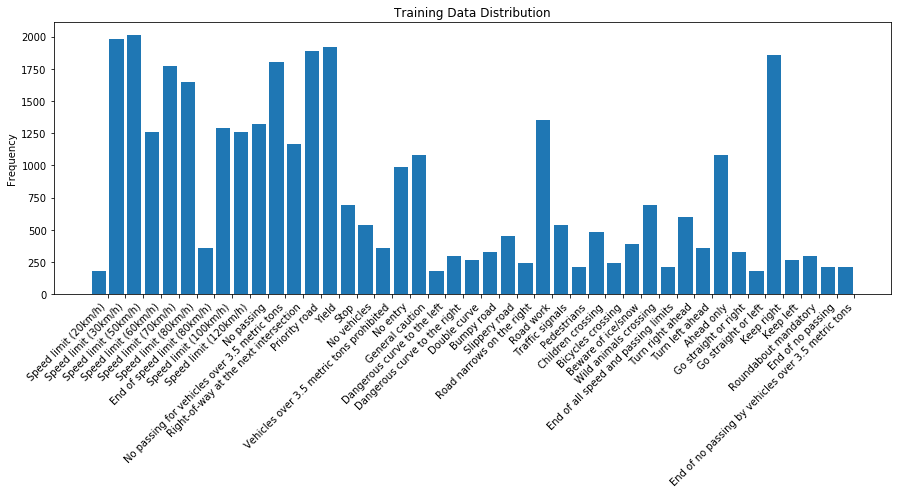

In [5]:
### Plot dataset distribution
unique, counts = np.unique(y_train, return_counts=True)
fig = plt.figure(figsize=(15,5))
plt.bar(unique, counts)

label = [label for label in label_names]

plt.xticks(np.arange(0.5,n_classes+0.5), label, rotation=45,ha='right')

plt.ylabel('Frequency')
plt.title('Training Data Distribution')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
# Convert to Grayscale

### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
'''
# Grayscale conversion

#Weighted average approach utilizing numpy functions. No need for OpenCV
#Y' = 0.299 R + 0.587 G + 0.114 B 

X_train_gray = np.dot(X_train[...][...,:3],[0.299,0.587,0.114])
X_test_gray = np.dot(X_test[...][...,:3],[0.299,0.587,0.114])
'''

# Variable names defined for convenience
X_train_gray = X_train
X_valid_gray = X_valid
X_test_gray = X_test

# Normalize data (Zero-Mean)
X_train_gray_norm = (X_train_gray - np.mean(X_train_gray))/np.std(X_train_gray)
X_valid_gray_norm = (X_valid_gray - np.mean(X_valid_gray))/np.std(X_valid_gray)
X_test_gray_norm = (X_test_gray - np.mean(X_test_gray))/np.std(X_test_gray)

encoder = preprocessing.LabelBinarizer()
y_train_oh = encoder.fit_transform(y_train)
y_valid_oh = encoder.fit_transform(y_valid)
y_test_oh = encoder.fit_transform(y_test)


In [7]:

### Shuffle data

train_features, train_labels = shuffle(X_train_gray_norm, y_train_oh)
valid_features, valid_labels = shuffle(X_valid_gray_norm, y_valid_oh)

### Model Architecture

In [8]:
# Flatten/Reshape data
image_size = len(train_features[0])
n_input = image_size**2
num_channels = 3

train_features_f = np.reshape(train_features, [-1, image_size, image_size, num_channels])
valid_features_f = np.reshape(valid_features, [-1, image_size, image_size, num_channels])
X_test_gray_flat = np.reshape(X_test_gray_norm, [-1, image_size, image_size, num_channels])

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Helper Functions
def calc_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.01))


def calc_biases(length):
    return tf.Variable(tf.zeros(length))


def maxpool(ip, stride_len = 2):
    filter_size = [1, stride_len, stride_len, 1]
    return tf.nn.max_pool(ip, ksize = filter_size, strides = [1, stride_len, stride_len, 1], padding = 'VALID')

def dropout(layer, dropout_prob):
    return tf.nn.dropout(layer, dropout_prob)


def conv_layer(ip, weights, biases, stride_len = 1):
    '''
    input_layer_width -> Number of inputs from previous layer
    output_layer_width -> width of layer
    '''  
    c_layer = tf.nn.conv2d(ip, weights, strides = [1, stride_len, stride_len, 1], padding = 'VALID')
    c_layer = tf.nn.bias_add(c_layer, biases)
    
    c_layer = maxpool(c_layer, 2) #stride length for max_pool = 2
    
    c_layer = tf.nn.relu(c_layer)
    return c_layer


def reshape_layer(ip):
    '''
    Flatten or reshape conv_layer for input to fc_layer
    '''
    flat_layer = tf.reshape(ip, [-1, ip.get_shape()[1:4].num_elements()])
    
    #print("Flat Layer: %s" %flat_layer.get_shape())
    
    return flat_layer

def fully_conn_layer(ip, weights, biases):
    '''
    input_layer_width -> Number of inputs from previous flattened layer
    output_layer_width -> width of layer, or equal to number of classes for prediction layer
    '''  
    flat_input = reshape_layer(ip)
    fc_layer = tf.add(tf.matmul(flat_input, weights), biases)
    
    #print("FC Layer: %s" %fc_layer.get_shape())
    
    #Not applying ReLU here because this could be prediction layer
    return fc_layer

def plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cls_pred):
    test_cls = np.argmax(y_test_oh, axis=1)
    cm = confusion_matrix(y_true=test_cls,
                              y_pred=cls_pred)

    # Print the confusion matrix as text.
    #print(cm)
    
    rcParams['figure.figsize'] = 13,13
    
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

def print_test_accuracy():
    test_cls = np.argmax(y_test_oh, axis=1)
    cls_pred = np.zeros(shape=n_test, dtype=np.int)
    i = 0

    while i < n_test:
        j = min(i + batch_size, n_test)

        batch_x = X_test_gray_flat[i:j]
        batch_y = y_test_oh[i:j]
        
        feed_dict={network_input: batch_x, network_output: batch_y, keep_prob: 1.0}

        cls_pred[i:j] = session.run(label_pred_class, feed_dict=feed_dict)

        i = j
    
    correct = (test_cls == cls_pred)
    correct_sum = correct.sum()

    acc = float(correct_sum) / n_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, n_test))

    plot_confusion_matrix(cls_pred=cls_pred)

In [10]:
### Convnet model
def convnet_model(ip, weights_dict, biases_dict, dropout_prob):
    
    #First conv layer
    c_layer_1 = conv_layer(ip, weights_dict['layer_1'], biases_dict['layer_1'], stride_len = 1)
    c_layer_1 = dropout(c_layer_1, dropout_prob)
    
    #Second conv layer
    c_layer_2 = conv_layer(c_layer_1, weights_dict['layer_2'], biases_dict['layer_2'], stride_len = 1)
    c_layer_2 = dropout(c_layer_2, dropout_prob)
    
    #FC Layer
    fc_layer = fully_conn_layer(c_layer_2, weights_dict['fc_layer'], biases_dict['fc_layer'])
    
    fc_layer = tf.nn.relu(fc_layer)
    fc_layer = dropout(fc_layer, dropout_prob)
    
    #Output fc layer
    out = fully_conn_layer(fc_layer, weights_dict['out'], biases_dict['out'])
    
    return out

In [11]:
# Dimensions
layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'fc_layer': 1024,
    'out': n_classes
} # number of filters

filter_size = {
    'layer_1': 5,
    'layer_2': 5
} # conv filter size


# Weights and biases
weights_dict = {
    'layer_1': calc_weights([filter_size['layer_1'], filter_size['layer_1'] , num_channels, layer_width['layer_1']]),
    'layer_2': calc_weights([filter_size['layer_2'], filter_size['layer_2'] , layer_width['layer_1'], layer_width['layer_2']]),
    'fc_layer': calc_weights([ 1600, layer_width['fc_layer']]),
    'out': calc_weights([layer_width['fc_layer'], layer_width['out']])
}

biases_dict = {
    'layer_1': calc_biases([layer_width['layer_1']]),
    'layer_2': calc_biases([layer_width['layer_2']]),
    'fc_layer': calc_biases([layer_width['fc_layer']]),
    'out': calc_biases([layer_width['out']])
}

# Define Parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 40
display_step = 1

# Input graph for TF
network_input = tf.placeholder("float", [None, image_size, image_size, num_channels])
network_output = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

logits = convnet_model(network_input, weights_dict, biases_dict, keep_prob)

label_pred = tf.nn.softmax(logits)
label_pred_class = tf.argmax(label_pred, 1)

# Cost function and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, network_output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Check if predictions are correct.
correct_prediction = tf.equal(label_pred_class, tf.argmax(network_output, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Initialize variables
init = tf.global_variables_initializer()
#init = tf.initialize_all_variables()

batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

total_time = time.time()
# Launch graph
session = tf.Session()
session.run(init)
    
# Training cycle
for epochs in range(training_epochs):
    start_time = time.time()
    avg_cost = 0.
    total_batch = int(len(train_features)/batch_size)

    train_features_f, train_labels = shuffle(train_features_f, train_labels)
    valid_features_f, valid_labels = shuffle(valid_features_f, valid_labels)

    for i in range(total_batch):
        idx_l = i*batch_size
        idx_h = idx_l + batch_size

        batch_x = train_features_f[idx_l:idx_h]
        batch_y = train_labels[idx_l:idx_h]

        _,c = session.run([optimizer, cost], feed_dict = {network_input: batch_x, network_output: batch_y, keep_prob: 0.5})

        # Compute average loss
        avg_cost += c / total_batch


    # Log every 50 batches
        if not i % 50:
            # Calculate Training and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict={network_input: train_features_f, network_output: train_labels, keep_prob: 0.5 })
            validation_accuracy = session.run(accuracy, feed_dict={network_input: valid_features_f, network_output: valid_labels, keep_prob: 1})

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(50 + previous_batch)
            loss_batch.append(c)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)


    # Display logs per epoch step
    if epochs % display_step == 0:
        print("Epoch:", '%04d' % (epochs+1), "cost=", \
            "{:.9f}".format(avg_cost))
    end_time = time.time() - start_time
    print("Time after epoch: %s" %end_time)

    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict={network_input: valid_features_f, network_output: valid_labels, keep_prob: 1})

print("Optimization Finished!")

test_accuracy = session.run(accuracy, feed_dict = {network_input: X_test_gray_flat, network_output: y_test_oh, keep_prob: 1})
print("Training Accuracy:", training_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch)

final_time = time.time() - total_time
print("Time taken: %s" %final_time)

ResourceExhaustedError: OOM when allocating tensor with shape[34799,28,28,32]
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_0/_21, Variable/read)]]
	 [[Node: Mean_1/_25 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_104_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Conv2D', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-f7ff564a96d5>", line 41, in <module>
    logits = convnet_model(network_input, weights_dict, biases_dict, keep_prob)
  File "<ipython-input-10-61e5be90a498>", line 5, in convnet_model
    c_layer_1 = conv_layer(ip, weights_dict['layer_1'], biases_dict['layer_1'], stride_len = 1)
  File "<ipython-input-9-d7c860d34f33>", line 26, in conv_layer
    c_layer = tf.nn.conv2d(ip, weights, strides = [1, stride_len, stride_len, 1], padding = 'VALID')
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[34799,28,28,32]
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_0/_21, Variable/read)]]
	 [[Node: Mean_1/_25 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_104_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import cv2

images = os.listdir("test_images/")

fig = plt.figure(figsize=(12, 5))

test_images = []

# Read in test images
for idx,val in enumerate(images):
    #reading in an image
    image = cv2.imread('test_images/' + images[idx])
    if len(image.shape) > 2 and image.shape[2] == 4:
        #convert the image from RGBA2RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if image.shape[0] != 32:
        
        image = cv2.resize(image, (32, 32))
    test_images.append(image)


# Create subplots in figure
for r in range(1,len(test_images)+1):
    img = fig.add_subplot(2,4,r)
    plt.imshow(test_images[r-1])
    img.set_xticks([])
    img.set_yticks([])

plt.show()

In [ ]:
### Preprocess images
# The images are already 32x32
image_size = len(train_features[0])
num_channels = 3

# Normalize data (Zero-Mean)
test_images_norm = (test_images - np.mean(test_images))/np.std(test_images)

# Reshape
test_images_norm_f = np.reshape(test_images_norm, [-1, image_size, image_size, num_channels])
print(test_images_norm_f.shape)

# Define True Labels
y_new_true = np.array([27, 23, 13, 17, 2, 29, 1, 14])
# Convert to One Hot Encoded Values
y_new_true_one_hot = (np.arange(n_classes) == y_new_true[:,None]).astype(np.float)

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
### Run the predictions here and use the model to output the prediction for each image.
label_pred = tf.nn.softmax(logits)
new_predictions = session.run(label_pred, feed_dict = {network_input: test_images_norm_f, network_output:y_new_true_one_hot , keep_prob: 1.0})
new_label_list = [np.argmax(row) for row in new_predictions]


fig = plt.figure(figsize=(12,5))
# Create subplots in figure
for r in range(1,len(test_images)+1):
    img = fig.add_subplot(2,4,r)
    plt.imshow(test_images[r-1])
    img.set_xlabel("Ground Truth: {0}, Pred: {1}".format(y_new_true[r-1],new_label_list[r-1]))
    img.set_xticks([])
    img.set_yticks([])

plt.show()

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 